In [ ]:
# Add any python libraries here

import enum
from zlib import Z_FIXED
import numpy as np
import cv2

import dlib
import matplotlib.pyplot as plt

from tqdm import tqdm
import pickle
import copy
import random
from google.colab.patches import cv2_imshow
import pandas as pd

from scipy import interpolate

In [ ]:


def minmax(image):
  image=(image - np.min(image))/np.ptp(image)
  return image

def getFacialFeatures(image):
    dup_image=image.copy()
    gray = cv2.cvtColor(dup_image, cv2.COLOR_BGR2GRAY)
    hog_face_detector = dlib.get_frontal_face_detector()
    dlib_facelandmark = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    faces = hog_face_detector(gray)
    print(faces)
    # print(faces)  Output: rectangles[[(194, 624) (452, 882)], [(968, 538) (1226, 796)]]
    face_landmarks_li=[]
    face_points = [] 
    for face in faces:
        fp = np.zeros((68,2))
        face_landmarks=dlib_facelandmark(gray,face)
        face_landmarks_li.append(face_landmarks)
        for i in range(0,68):

            x=face_landmarks.part(i).x
            y=face_landmarks.part(i).y
            fp[i,0] = x
            fp[i,1] = y
            cv2.circle(dup_image,(x,y),2,(0,0,255),-1)
        face_points.append(fp)

    return dup_image,face_landmarks_li,faces,face_points


def getDelenauy(face_landmarks_li,features_img):

    size=features_img.shape
    rect=(0,0,size[1],size[0])
    # print(len(face_landmarks_li[1]))
    # print(face_landmarks_li[1])
    li_of_triangleList=[]
    subdiv=cv2.Subdiv2D(rect)
    points1=[]  
    face1_landmark=face_landmarks_li[0]
    point2index={}
    #This loop is only for making the subdiv points##
    for i in range(0,68):
        x=face1_landmark.part(i).x
        y=face1_landmark.part(i).y
        point2index[(x,y)]=i
        points1.append((x,y))
    for p in points1:
        subdiv.insert(p)
    triangleList1=subdiv.getTriangleList()
    li_of_triangleList.append(triangleList1)
    ## Make Triangle List 2 or destination face 
    face2_landmark=face_landmarks_li[1]
    triangleList2=[]

    for t in triangleList1:
        t_li=[]

        pt1=((t[0]),(t[1]))
        pt2=((t[2]),(t[3]))
        pt3=((t[4]),(t[5]))

        pt1_in_2_index=point2index[pt1]
        pt2_in_2_index=point2index[pt2]
        pt3_in_2_index=point2index[pt3]

        t_li.append(face2_landmark.part(pt1_in_2_index).x)
        t_li.append(face2_landmark.part(pt1_in_2_index).y)
        t_li.append(face2_landmark.part(pt2_in_2_index).x)
        t_li.append(face2_landmark.part(pt2_in_2_index).y)
        t_li.append(face2_landmark.part(pt3_in_2_index).x)
        t_li.append(face2_landmark.part(pt3_in_2_index).y)

        triangleList2.append(t_li)

    li_of_triangleList.append(triangleList2)

    for t in triangleList1:

        pt1=(int(t[0]),int(t[1]))
        pt2=(int(t[2]),int(t[3]))
        pt3=(int(t[4]),int(t[5]))

        cv2.line(features_img,pt1,pt2,(255,255,255),1)
        cv2.line(features_img,pt2,pt3,(255,255,255),1)
        cv2.line(features_img,pt3,pt1,(255,255,255),1)

        # break

    for t in triangleList2:

        pt1=(int(t[0]),int(t[1]))
        pt2=(int(t[2]),int(t[3]))
        pt3=(int(t[4]),int(t[5]))

        cv2.line(features_img,pt1,pt2,(255,255,255),1)
        cv2.line(features_img,pt2,pt3,(255,255,255),1)
        cv2.line(features_img,pt3,pt1,(255,255,255),1)
    # cv2.imshow("Delanauy",features_img)
    # cv2.waitKey(0)
    print(len(triangleList1))
    print(len(triangleList2))

    return li_of_triangleList,features_img


def getInverse(li_of_triangleList):
    face_1_triangle_li=li_of_triangleList[0]
    face_2_triangle_li=li_of_triangleList[1]
    lamb=10e-6
    face1_inverse_li=[]
    for j,t in enumerate(face_1_triangle_li):

        pt1=((t[0]),(t[1]))
        pt2=((t[2]),(t[3]))
        pt3=((t[4]),(t[5]))

        B_matrix=np.array([[pt1[0],pt2[0],pt3[0]],
                            [pt1[1],pt2[1],pt3[1]],
                            [1,1,1]

                        ])

        B_matrix_inv=np.linalg.inv(B_matrix+lamb*np.identity(3))
        face1_inverse_li.append(B_matrix_inv)

    face2_inverse_li=[]
    for t in face_2_triangle_li:
        pt1=((t[0]),(t[1]))
        pt2=((t[2]),(t[3]))
        pt3=((t[4]),(t[5]))
        B_matrix=np.array([[pt1[0],pt2[0],pt3[0]],
                            [pt1[1],pt2[1],pt3[1]],
                            [1,1,1]

                        ])
        B_matrix_inv=np.linalg.inv(B_matrix+lamb*np.identity(3))

        face2_inverse_li.append(B_matrix_inv)

    return face1_inverse_li,face2_inverse_li

def mask_from_points(size, points,erode_flag=1):
    radius = 10  # kernel size
    kernel = np.ones((radius, radius), np.uint8)

    mask = np.zeros(size, np.uint8)
    cv2.fillConvexPoly(mask, cv2.convexHull(np.int32(points)), 255)
    if erode_flag:
        mask = cv2.erode(mask, kernel,iterations=1)

    return mask


def doBaryCoords(base_img,face1_inverse_li,face2_inverse_li,triangleLists,faces_rectangle,face_points):

    temp_img=base_img.copy()

    face1_rectangle=faces_rectangle[1]

    x_range_min,x_range_max=face1_rectangle.left(),face1_rectangle.right()
    y_range_min,y_range_max=face1_rectangle.top(),face1_rectangle.bottom()

    point_matrix_face_2=[]

    for x in range(x_range_min,x_range_max+1):
        for y in range(y_range_min,y_range_max+1):
            point_matrix_face_2.append([x,y,1])

    point_matrix_face_2=np.array(point_matrix_face_2)
    point_matrix_face_2=point_matrix_face_2.T

    # print(f'Number of points in Face 2: {(point_matrix_face_2.shape)}')


    ###########FOR SOURCE TRIANGLES#####
    A_matrix_li=[]
    for t in triangleLists[0]:
        pt1=((t[0]),(t[1]))
        pt2=((t[2]),(t[3]))
        pt3=((t[4]),(t[5]))

        A_matrix=np.array([[pt1[0],pt2[0],pt3[0]],
                            [pt1[1],pt2[1],pt3[1]],
                            [1,1,1]

                        ])

        A_matrix_li.append(A_matrix)

    ###############################################



    ################For making a meshgrid of the whole image#######################
    height,width,_=temp_img.shape

    x=np.arange(width)
    y=np.arange(height)

    # xx,yy=np.meshgrid(x,y)
    # print(base_img[:,:,0].shape)

    interpolate_function_X=interpolate.interp2d(x, y, base_img[:,:,0])
    interpolate_function_Y=interpolate.interp2d(x, y, base_img[:,:,1])
    interpolate_function_Z=interpolate.interp2d(x, y, base_img[:,:,2])

    ######################################################################################
    sum=0
    for triangle_index,triangle_inverse in enumerate(face2_inverse_li):

        barycentric_coords=np.matmul(triangle_inverse,point_matrix_face_2)

        ### Take only the inside points#####

        barycentric_coords_T=barycentric_coords.T

        df=pd.DataFrame(barycentric_coords_T,columns=['alpha','beta','gamma'])
        df_points=pd.DataFrame(point_matrix_face_2.T,columns=['x','y','1'])

        df=df.join(df_points)

        df=df.loc[(df['alpha']<=1) & (df['alpha']>=0) & (df['beta']>=0) & (df['beta']<=1) & (df['gamma']>=0) & (df['gamma']<1) & (df['alpha']+df['beta']+df['gamma']<=1) & (df['gamma']<1) & (df['alpha']+df['beta']+df['gamma']>0) ]
        bary_temp=df[["alpha","beta","gamma"]].to_numpy()
        destination_x_y=df[["x","y"]].to_numpy()
        # print(destination_x_y.shape)
        sum+=destination_x_y.shape[0]
        bary_temp=bary_temp.T
        corresponding_triangle_matrix=A_matrix_li[triangle_index]
        points_in_face_A=np.matmul(corresponding_triangle_matrix,bary_temp)
        points_in_face_A_T=points_in_face_A.T
        #Divide 1st and 2nd column by the 3rd column
        points_in_face_A_T[:, 0] = points_in_face_A_T[:, 0] / points_in_face_A_T[:, 2]
        points_in_face_A_T[:, 1] = points_in_face_A_T[:, 1] / points_in_face_A_T[:, 2]
        points_in_face_A_T[:, 2] = 1
        ##Changing the face
        for idx in range(len(points_in_face_A_T)):
            x_dest,y_dest=destination_x_y[idx]
            # print(x_dest,y_dest)
            z_x= interpolate_function_X(points_in_face_A_T[idx][0],points_in_face_A_T[idx][1])
            z_y= interpolate_function_Y(points_in_face_A_T[idx][0],points_in_face_A_T[idx][1])
            z_z=interpolate_function_Z(points_in_face_A_T[idx][0],points_in_face_A_T[idx][1])

            temp_img[y_dest,x_dest,0]=z_x
            temp_img[y_dest,x_dest,1]=z_y
            temp_img[y_dest,x_dest,2]=z_z

    face1_rectangle=faces_rectangle[0]
    x_range_min,x_range_max=face1_rectangle.left(),face1_rectangle.right()
    y_range_min,y_range_max=face1_rectangle.top(),face1_rectangle.bottom()

    src=base_img[y_range_min:y_range_max,x_range_min:x_range_max]
    # print(src.shape)
    dst=temp_img.copy()
    face2_rectangle=faces_rectangle[1]
    x_range_min,x_range_max=face2_rectangle.left(),face2_rectangle.right()
    y_range_min,y_range_max=face2_rectangle.top(),face2_rectangle.bottom()

    center=(int((y_range_min+y_range_max)/2),int((x_range_max+x_range_min)/2))
    f1_points=face_points[0]
    mask=mask_from_points((src.shape[0],src.shape[1]), f1_points, erode_flag=0)
    temp_img = cv2.seamlessClone(src, dst, mask, tuple(center), cv2.NORMAL_CLONE)
    print(sum)

    face1_rectangle=faces_rectangle[0]

    x_range_min,x_range_max=face1_rectangle.left(),face1_rectangle.right()
    y_range_min,y_range_max=face1_rectangle.top(),face1_rectangle.bottom()

    point_matrix_face_1=[]

    for x in range(x_range_min,x_range_max+1):
        for y in range(y_range_min,y_range_max+1):
            point_matrix_face_1.append([x,y,1])

    point_matrix_face_1=np.array(point_matrix_face_1)
    point_matrix_face_1=point_matrix_face_1.T

    print(f'Number of points in Face 1: {(point_matrix_face_1.shape)}')

    ###########FOR SOURCE TRIANGLES#####
    A_matrix_li=[]
    for t in triangleLists[1]:
        pt1=((t[0]),(t[1]))
        pt2=((t[2]),(t[3]))
        pt3=((t[4]),(t[5]))

        A_matrix=np.array([[pt1[0],pt2[0],pt3[0]],
                            [pt1[1],pt2[1],pt3[1]],
                            [1,1,1]

                        ])

        A_matrix_li.append(A_matrix)

    ###############################################

    sum=0
    for triangle_index,triangle_inverse in enumerate(face1_inverse_li):
        barycentric_coords=np.matmul(triangle_inverse,point_matrix_face_1)
        ### Take only the inside points#####
        barycentric_coords_T=barycentric_coords.T
        df=pd.DataFrame(barycentric_coords_T,columns=['alpha','beta','gamma'])
        df_points=pd.DataFrame(point_matrix_face_1.T,columns=['x','y','1'])

        df=df.join(df_points)

        df=df.loc[(df['alpha']<=1) & (df['alpha']>=0) & (df['beta']>=0) & (df['beta']<=1) & (df['gamma']>=0) & (df['gamma']<1) & (df['alpha']+df['beta']+df['gamma']<=1) & (df['gamma']<1) & (df['alpha']+df['beta']+df['gamma']>0) ]
        bary_temp=df[["alpha","beta","gamma"]].to_numpy()
        destination_x_y=df[["x","y"]].to_numpy()
        # print(destination_x_y.shape)
        sum+=destination_x_y.shape[0]
        bary_temp=bary_temp.T
        corresponding_triangle_matrix=A_matrix_li[triangle_index]
        points_in_face_A=np.matmul(corresponding_triangle_matrix,bary_temp)
        points_in_face_A_T=points_in_face_A.T

        #Divide 1st and 2nd column by the 3rd column

        points_in_face_A_T[:, 0] = points_in_face_A_T[:, 0] / points_in_face_A_T[:, 2]
        points_in_face_A_T[:, 1] = points_in_face_A_T[:, 1] / points_in_face_A_T[:, 2]
        points_in_face_A_T[:, 2] = 1

        ##Changing the face

        for idx in range(len(points_in_face_A_T)):

            x_dest,y_dest=destination_x_y[idx]
            z_x= interpolate_function_X(points_in_face_A_T[idx][0],points_in_face_A_T[idx][1])
            # print(points_in_face_A_T[idx][0])
            z_y= interpolate_function_Y(points_in_face_A_T[idx][0],points_in_face_A_T[idx][1])
            z_z=interpolate_function_Z(points_in_face_A_T[idx][0],points_in_face_A_T[idx][1])

            temp_img[y_dest,x_dest,0]=z_x
            temp_img[y_dest,x_dest,1]=z_y
            temp_img[y_dest,x_dest,2]=z_z
    
    face2_rectangle=faces_rectangle[1]
    x_range_min,x_range_max=face2_rectangle.left(),face2_rectangle.right()
    y_range_min,y_range_max=face2_rectangle.top(),face2_rectangle.bottom()  
    src=base_img[y_range_min:y_range_max,x_range_min:x_range_max]

   # print(src.shape)

    dst=temp_img.copy()

    face1_rectangle=faces_rectangle[0]
    x_range_min,x_range_max=face1_rectangle.left(),face1_rectangle.right()
    y_range_min,y_range_max=face1_rectangle.top(),face1_rectangle.bottom()
    center=(int((y_range_min+y_range_max)/2),int((x_range_max+x_range_min)/2))
    f2_points=face_points[1]
    mask=mask_from_points((src.shape[0],src.shape[1]), f2_points, erode_flag=0)
    temp_img = cv2.seamlessClone(src, dst, mask, tuple(center), cv2.NORMAL_CLONE)

        # break

    print(sum)
    cv2_imshow(temp_img)
    cv2.waitKey(0)
    return 0





rectangles[[(79, 272) (203, 397)], [(452, 231) (577, 355)]]
113
113
9578
Number of points in Face 1: (3, 15750)
10153


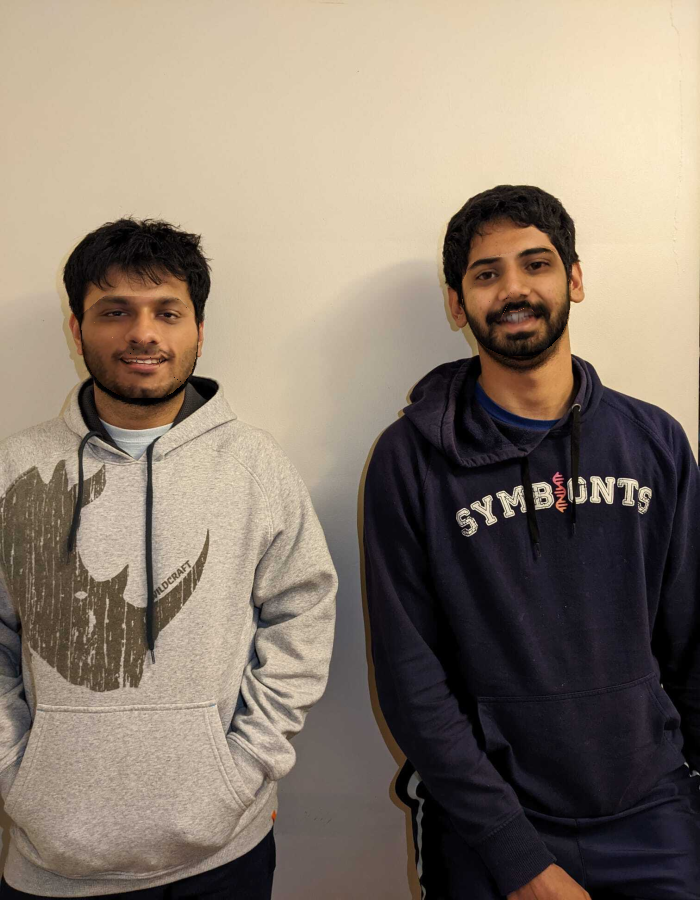

In [ ]:
def doAll():

    base_img=cv2.imread('both.jpeg')
    base_img=cv2.resize(base_img,(700,900),interpolation = cv2.INTER_AREA)
    img_features,face_landmarks_li,faces_rectangle,face_points=getFacialFeatures(base_img)
    li_of_triangleList,delanauy_img=getDelenauy(face_landmarks_li,img_features)
    face1_inverse_li,face2_inverse_li=getInverse(li_of_triangleList)
    warped_img1=doBaryCoords(base_img,face1_inverse_li,face2_inverse_li,li_of_triangleList,faces_rectangle,face_points)





   

doAll()